# Прогнозирование оттока клиентов фитнесс-центра

**Заказчик:** сеть фитнес-центров «Культурист-датасаентист».

**Входные данные:** данные из базы данных заказчика (анкетные данные клиентов, журнал посещений и покупок, статус абонемента клиента).

**Цель проекта:** сформулировать рекомендации для стратегии взаимодействия с клиентами и их удержания.

**Задачи проекта:**

- провести предварительный анализ входных данных;
- построить модель бинарной классификации клиентов для прогнозирования оттока клиента в следующем месяце;
- разбить клиентов на характерные кластеры, провести предварительный анализ признаков выделенных кластеров, их склонность к оттоку;
- определить потенциальные риски данного исследования, возможности их устранения;  
- дать рекомендации по дальнейшему развитию данного исследования.

---
## Начальная подготовка

In [1]:
# !pip install seaborn --upgrade

In [2]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
# ПОЛЕЗНЫЕ ФУНКЦИИ

#--------------------------------------------------------------------
# загрузка данных

def df_read_csv(path, sep=','):
    
    try:
        return pd.read_csv(path, sep)
    except Exception:
        print('Ошибка при загрузке файла')


#--------------------------------------------------------------------
# определение имени таблицы

def df_name(df):
    
    return [name for name in globals() if globals()[name] is df][0]


#--------------------------------------------------------------------
# вывод таблиц с выравниванием полей типа obect по левому краю
# !!! зависает, если выводимая таблица не умещается в установленный лимит строк !!!

def display_left(df):
    
    object_type_fields = []
    for column in df.select_dtypes('object').columns:   # составление списка полей типа object
        object_type_fields.append(column)
    
    # выравнивание значений
    left_aligned_df = df.style.set_properties(
                                              subset=object_type_fields,
                                              **{'text-align': 'left'}
                                             )
    # выравнивание заголовков
    left_aligned_df = left_aligned_df.set_table_styles(
                                                       [dict(subset=object_type_fields,
                                                             selector='th',
                                                             props=[('text-align', 'left')]
                                                            )
                                                       ]
                                                      )
    return display(left_aligned_df)


#--------------------------------------------------------------------
# первичная информация о таблице

def basic_info(df, sample='sample', qnty=10):

    print(f.BOLD + '\n'*2 + f'таблица {df_name(df)}' + f.END, end=' ' + theme_char*20 + '\n\n')

    # метод info()
    print(df.info())

    # несколько записей
    if sample == 'sample':
        display_left(df.sample(qnty))
    elif sample == 'head':
        display_left(df.head(qnty))
    elif sample == 'tail':
        display_left(df.tail(qnty))
    
    # метод describe()
    print(df.describe(), '\n')
#     print(df.describe(exclude=['int', 'int64', 'uint', 'uint64', 'float', 'float64']), '\n')


#--------------------------------------------------------------------
# перевод значений полей типа object в нижний регистр

def object_fields_lower(df):  # dataframe
    
    for i in range(len(df.dtypes)):
        if df.dtypes[i] == 'object':
            df[df.columns[i]] = df[df.columns[i]].str.lower()


#--------------------------------------------------------------------
# проверка на дубликаты

def duplicated_test(df):
    print('\n',
          f'количество полных дубликатов в таблице {f.BOLD + df_name(df) + f.END}: {df.duplicated().sum()}',
          '\n')


#--------------------------------------------------------------------
# числовые значения для вертикальных bar-графиков
# доработать до универсальной (+ горизонтальные)

def bar_annotate(ax, decimals=0):
    
    max_height = 0
    for p in ax.patches:
        if p.get_height() > max_height:
            max_height = p.get_height()
    
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + max_height*0.01
        value = f'{p.get_height():.{decimals}f}'
        ax.text(_x, _y, value, ha="center")

In [4]:
# ДЛЯ ОФОРМЛЕНИЯ

#--------------------------------------------------------------------------
# для свободного пространства (пустые строки)

def space(num=1):
    print('\n' * num)
    
#--------------------------------------------------------------------------
# для украшения и разнообразия: ∻ ⋰ ≋

theme_char = '≋'

#--------------------------------------------------------------------------
# для оформления текста
class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

### Настройки

In [5]:
# стиль графиков
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plot_dpi = 150              # dpi для рендеринга графиков

# цвета для графиков
colors = ['darkcyan', 'cyan']

# внешний вид
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 100)

### Загрузка данных

In [6]:
# входные данные
data = df_read_csv('/datasets/gym_churn.csv')

---
## Проверка и подготовка данных

### Общая информация о входных данных

In [7]:
basic_info(data)



таблица data ≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
2609,1,1,0,0,1,1,0,32,20.3,1,0,2.24,2.17,0
2369,1,1,1,1,0,6,0,27,274,6,8,1.9,1.72,0
3790,0,1,0,0,1,1,1,24,44,1,9,2.5,2.5,0
3814,0,1,0,0,1,12,0,31,147,12,6,1.71,1.62,0
474,0,1,1,1,0,1,0,29,226,1,2,2.29,2.33,0
1692,0,1,1,1,1,12,0,25,56.4,11,10,1.68,1.83,0
274,0,1,1,1,1,12,1,30,132,9,5,0,0.0897,0
347,0,0,1,0,1,6,0,33,42.9,6,4,1.47,1.29,0
211,1,1,0,0,1,1,1,25,140,1,0,2.38,1.83,1
1215,0,0,0,1,1,1,0,27,211,1,2,1.35,0.559,1


        gender  Near_Location   Partner  Promo_friends     Phone  \
count  4000.00       4000.000  4000.000       4000.000  4000.000   
mean      0.51          0.845     0.487          0.308     0.903   
std       0.50          0.362     0.500          0.462     0.295   
min       0.00          0.000     0.000          0.000     0.000   
25%       0.00          1.000     0.000          0.000     1.000   
50%       1.00          1.000     0.000          0.000     1.000   
75%       1.00          1.000     1.000          1.000     1.000   
max       1.00          1.000     1.000          1.000     1.000   

       Contract_period  Group_visits       Age  Avg_additional_charges_total  \
count         4000.000      4000.000  4000.000                      4000.000   
mean             4.681         0.412    29.184                       146.944   
std              4.550         0.492     3.258                        96.356   
min              1.000         0.000    18.000                     

### Базовая подготовка

In [8]:
# переименование полей
data = data.rename(
             columns={
              'Near_Location':'near',                          # проживание или работа в районе фитнес-центра
              'Promo_friends':'promo',                         # факт первоначальной записи в рамках акции
              'Contract_period':'contract',                    # длительность текущего действующего абонемента (мес.)
              'Month_to_end_contract':'contract_ends',         # срок до окончания текущего абонемента (мес.)
              'Group_visits':'groups',                         # факт посещения групповых занятий
              'Avg_class_frequency_total':'freq_total',        # ср. частота посещений за время абонемента (раз/нед.)
              'Avg_class_frequency_current_month':'freq_curr', # ср. частота посещений в предыдущем месяце  (раз/нед.)
              'Avg_additional_charges_total':'charges_total',  # суммарная выручка от доп. услуг фитнес-центра
                     }
                  )

# перевод названий всех полей в нижний регистр
data.columns = data.columns.str.lower()

### Изменение типов данных

In [9]:
# проверка, все ли значения в поле сontract_ends — целые числа
display(data.contract_ends.value_counts().sort_index())

# изменение типа данных на целочисленный
data.contract_ends = data.contract_ends.astype('int64')

1.0     2207
2.0       14
3.0       23
4.0       58
5.0      130
6.0      645
7.0       25
8.0       38
9.0       73
10.0      82
11.0     181
12.0     524
Name: contract_ends, dtype: int64

### Проверка дубликатов

In [10]:
# проверка на дубликаты
duplicated_test(data)


 количество полных дубликатов в таблице data: 0 



> **Итог по разделу**
>
> Пропуски, дубликаты, аномалии в данных не замечены.  
> Названия полей изменены на более удобные.  
> Тип поля `contract_ends` изменен на целочисленный.

---
## Исследовательский анализ данных (EDA)

### Общая информация о входных данных (повторно, в более удобном виде)

In [11]:
# повторный вывод в более удобном виде;
# одновременно: проверка внесенных изменений

basic_info(data, qnty=3)



таблица data ≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋≋

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender           4000 non-null int64
near             4000 non-null int64
partner          4000 non-null int64
promo            4000 non-null int64
phone            4000 non-null int64
contract         4000 non-null int64
groups           4000 non-null int64
age              4000 non-null int64
charges_total    4000 non-null float64
contract_ends    4000 non-null int64
lifetime         4000 non-null int64
freq_total       4000 non-null float64
freq_curr        4000 non-null float64
churn            4000 non-null int64
dtypes: float64(3), int64(11)
memory usage: 437.6 KB
None


,gender,near,partner,promo,phone,contract,groups,age,charges_total,contract_ends,lifetime,freq_total,freq_curr,churn
3587,1,1,1,0,1,6,0,36,253,6,11,3.73,3.85,0
108,0,0,0,0,1,1,1,30,167,1,7,2.34,2.49,0
2584,1,1,1,1,1,6,1,28,117,6,9,2.59,2.64,0


        gender      near   partner     promo     phone  contract    groups  \
count  4000.00  4000.000  4000.000  4000.000  4000.000  4000.000  4000.000   
mean      0.51     0.845     0.487     0.308     0.903     4.681     0.412   
std       0.50     0.362     0.500     0.462     0.295     4.550     0.492   
min       0.00     0.000     0.000     0.000     0.000     1.000     0.000   
25%       0.00     1.000     0.000     0.000     1.000     1.000     0.000   
50%       1.00     1.000     0.000     0.000     1.000     1.000     0.000   
75%       1.00     1.000     1.000     1.000     1.000     6.000     1.000   
max       1.00     1.000     1.000     1.000     1.000    12.000     1.000   

            age  charges_total  contract_ends  lifetime  freq_total  \
count  4000.000       4000.000       4000.000  4000.000    4000.000   
mean     29.184        146.944          4.323     3.725       1.879   
std       3.258         96.356          4.191     3.749       0.972   
min      18.0

In [12]:
# анализ значений поля lifetime

data.lifetime.value_counts().sort_index()

0     487
1     843
2     610
3     490
4     383
5     273
6     220
7     167
8     111
9     100
10     76
11     48
12     53
13     28
14     24
15     24
16     15
17     11
18      7
19      7
20      7
21      5
22      2
23      2
24      2
26      2
27      1
29      1
31      1
Name: lifetime, dtype: int64

Первичный анализ:

>– мужчин и женщин примерно поровну;

>– большинство клиентов живут или работают в том же районе, где находится фитнес-центр;

>– около половины клиентов — сотрудники "партнерской" программы;

>– почти треть клиентов использовала промо-код акции «приведи друга»:  
*для более плодотворного анализа хорошо бы знать, как долго длится акция, разовая они или повторяется, чтобы проанализировать связь оттока клиентов с потоком тех, кто пришел "попробовать";*

>– телефон указали 9 из 10 клиентов:  
*возможно, это ничего не значит (и люди просто не любят утечку персональных данных), а возможно, те, кто не указал телефон, сомневаются, что останутся клиентами, и не указли телефон, чтобы их не донимали дозвонами;*

>– средняя продолжительность контракта 4.7 месяца (вероятно, это хороший показатель), но медианное значение – 1 месяц:  
*возможно, много тех, кто "пробует"  — нужно узнать о проведенных недавно акциях;*  
*либо клуб активно расширяется;*  
*либо клуб открылся недавно (эта версия противоречит `lifetime`, но лучше проверить)*;

>– срок до конца абонемента практически не отличается от длительности абонемента, как будто все клиенты их недавно приобрели/продлили:  
*растет вероятность, что в жизни клуба происходят какие-то существенные перемены;*

>– многие клиенты посещают групповые занятия:  
*интерпретация этого показателя зависит от специфики клуба*;

>– средний возраст почти совпадает с медианным – 29 лет, максимальный – всего 41 год:  
*либо это молодежный клуб, либо так сказывается специфика района, партнерской программы или акций;*

>– среднее значение `lifetime` менее 4 месяцев, при том, что клуб открыт не менее 2.5 лет:  
*дополнительная оценка `lifetime` позволяет предположить, что в последние примерно 8 месяцев клуб активно увеличивает количество клиентов;*  
*в качестве версии можно предположить, что клуб открыт не более 1 года назад, а часть клиентов (с `lifetime` > 12) перешли в этот клуб из других клубов сети*;

>– текущая средняя частота посещений в неделю ниже значения за весь период на 6%.  
*это может быть связано с сезонностью;*  
*если клуб находится в фазе активного расширения, необходима дополнительная информация для интерпретации этого значения;*

>– отток на уровне 1/4 части клиентов для устоявшегося фитнес-клуба великоват, но для активно расширяющегося может быть вполне обычным явлением.

Для более продуктивного исследования необходимо больше информации о клубе: как давно открыт, является ли сетевым, есть ли выраженная направленность, какие программы и акции действовали/действуют и т.д.

Если клуб проводит кампанию по активному расширению, прогнозная модель, построенная в данном исследовании, может оказаться бесполезной, т.к. по окончании процесса расширения условия изменятся.

### Cредние значения признаков, сгруппированных по полю `churn`

In [13]:
# ratio показывает различие между значениями признаков для churn=0 и churn=1
# ratio всегда >= 1

def ratio(df):
    if df[0] == 0 or df[1] == 0:
        return 1
    if df[0] > df[1]:
        return df[0] / df[1]
    else:
        return df[1] / df[0]


churn_features = data.groupby('churn').mean().T.sort_index()

churn_features['ratio'] = churn_features.apply(ratio, axis=1)

churn_features = churn_features.rename(columns={0:'остались', 1:'ушли'})

display(
        churn_features
        .sort_values('ratio', ascending=False)
        .style
              .background_gradient('Reds', subset='ratio', high=1)
              .format('{:.3f}')
       )

# сохранение признаков в виде списка, отсортированного по предполагаемой силе связи с полем churn
# далее этот список будет использован при построении таблиц и графиков
features_sorted = (
                   churn_features
                   .sort_values('ratio', ascending=False)
                   .index
                   .to_list()
                  )

churn,остались,ушли,ratio
lifetime,4.712,0.991,4.757
contract,5.747,1.729,3.325
contract_ends,5.283,1.663,3.178
freq_curr,2.028,1.045,1.941
promo,0.354,0.184,1.924
groups,0.464,0.269,1.728
partner,0.534,0.355,1.503
charges_total,158.446,115.083,1.377
freq_total,2.025,1.475,1.373
near,0.873,0.768,1.137


>Чтобы выделить признаки, которые предположительно наиболее коррелируют с оттоком клиентов, оценим соотношение средних значений признаков для оставшихся и ушедших клиентов. Числитель и знаменатель при необходимости меняем местами так, чтобы дробь всегда была >=1.

### Гистограммы признаков, сгруппированные по полю `churn`



Гистограммы признаков по убыванию их предполагаемого влияния на отток клиентов





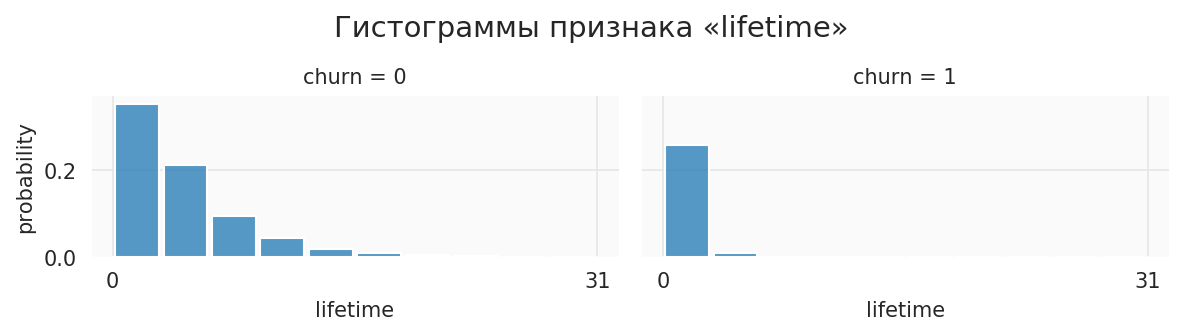

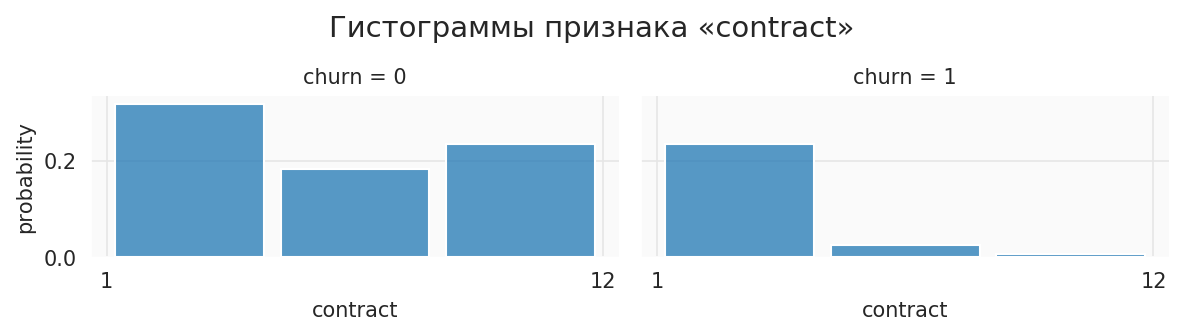

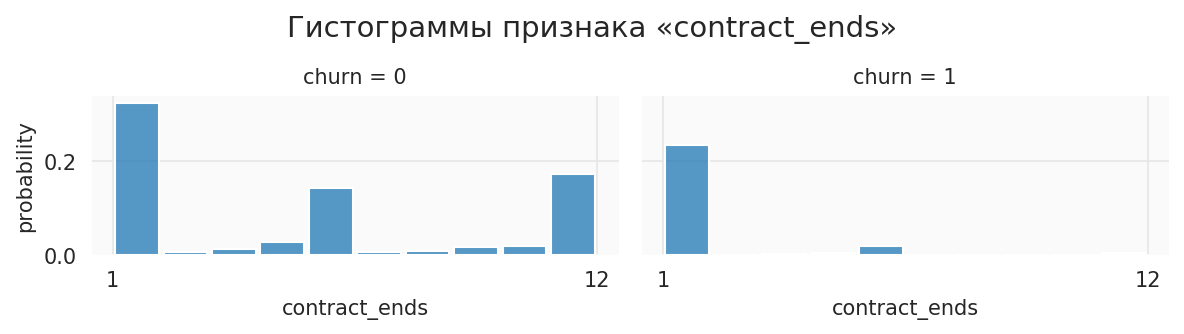

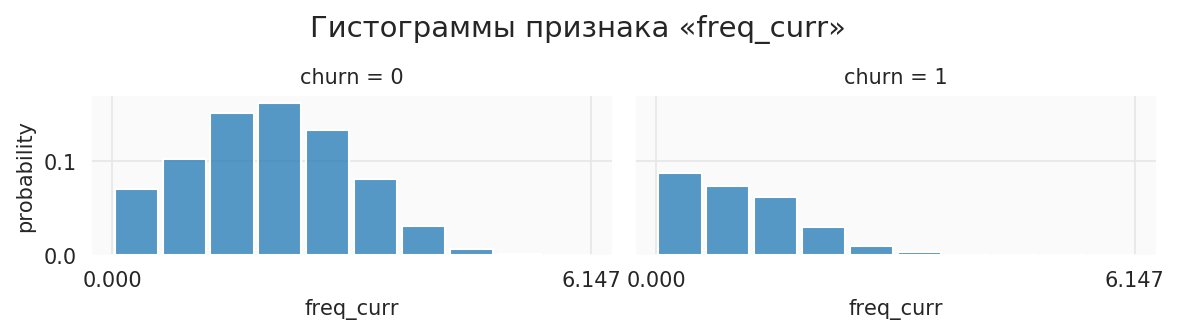

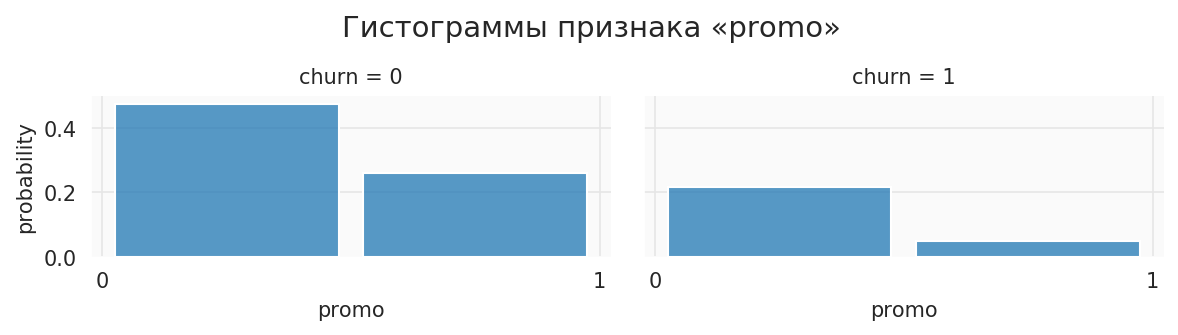

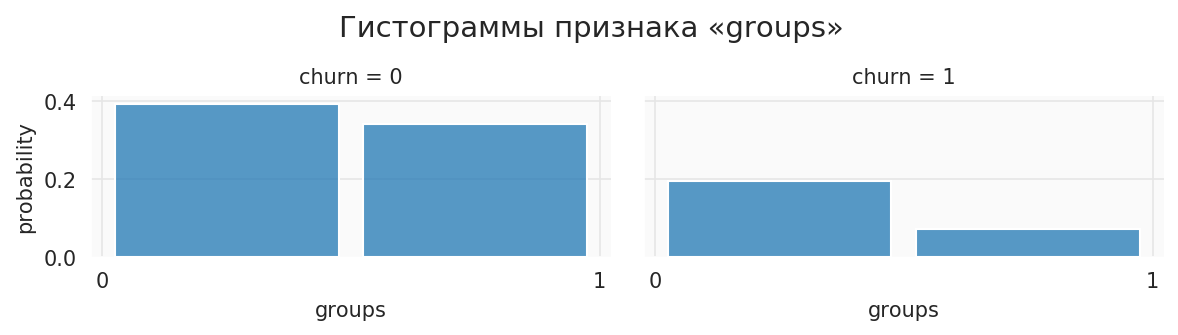

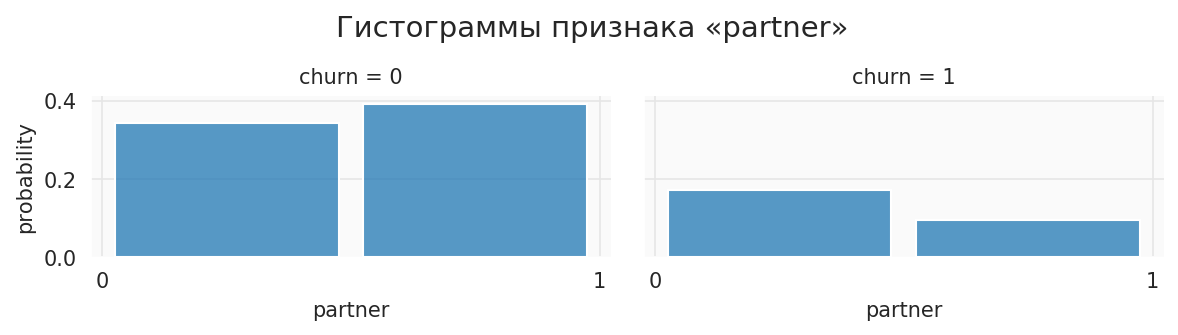

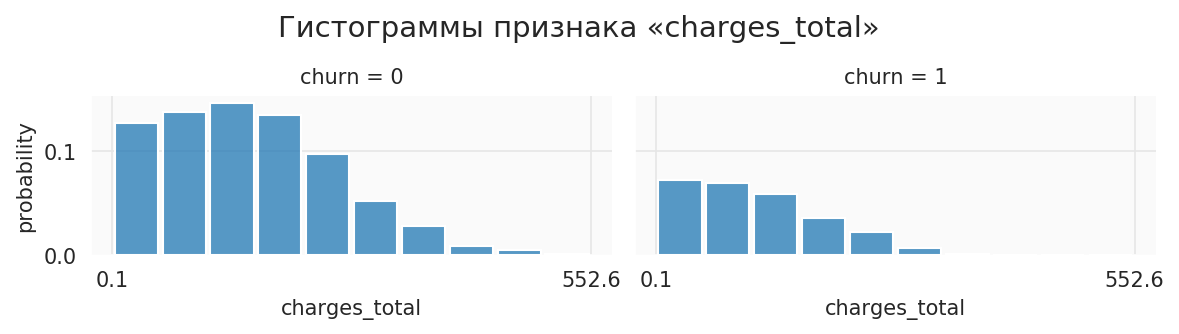

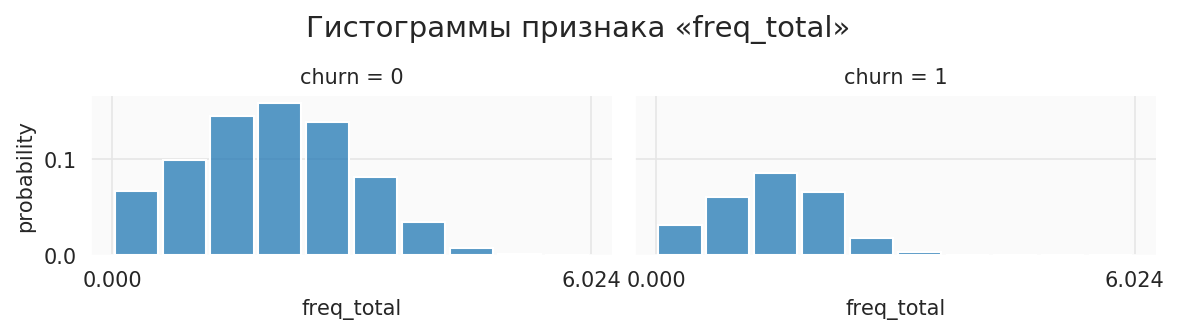

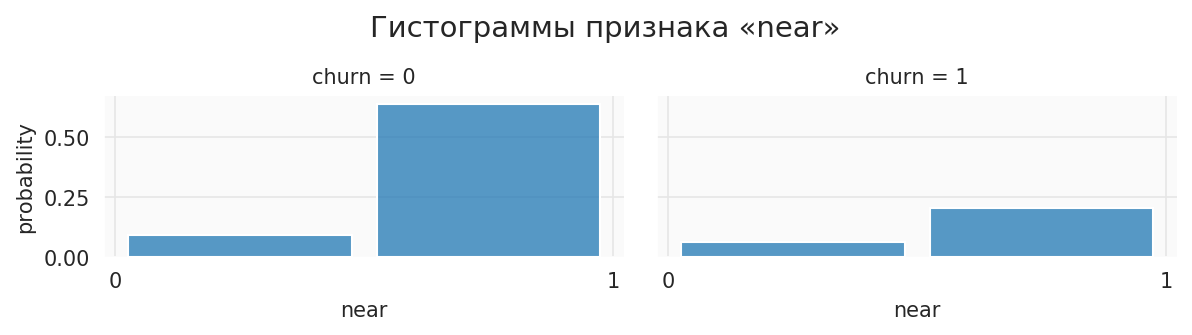

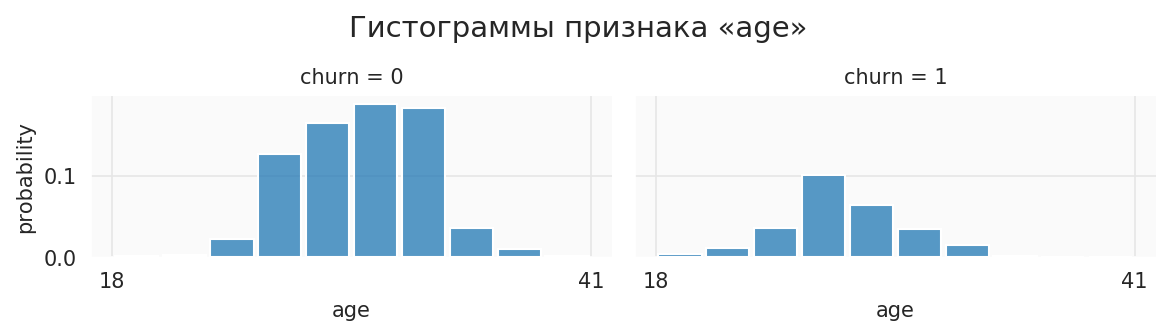

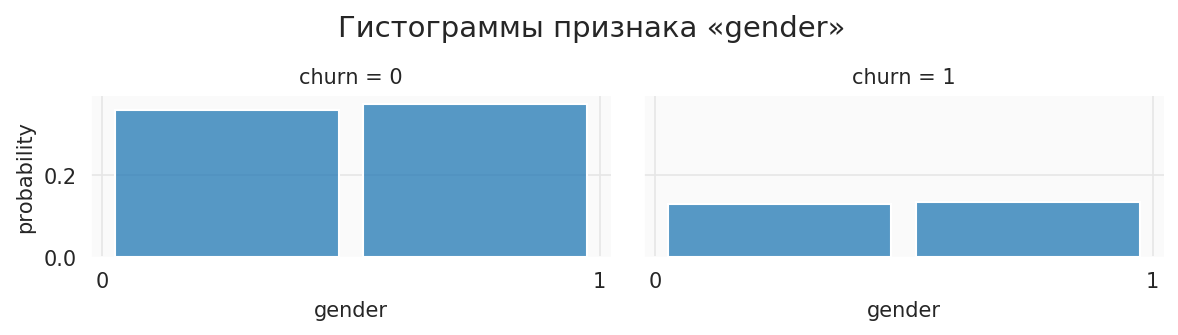

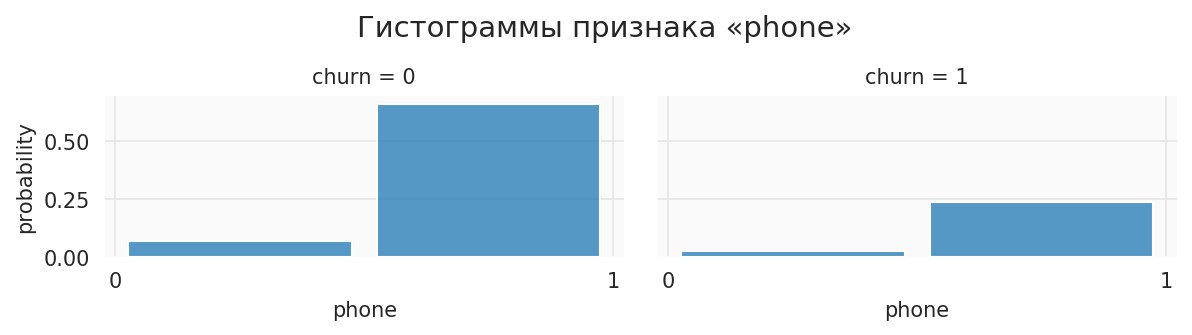

In [14]:
# признаки упорядочены по убыванию их предполагаемого влияния на целевую переменную

space()
print('Гистограммы признаков по убыванию их предполагаемого влияния на отток клиентов')

for column in features_sorted:

    # определение количества корзин
    if data[column].nunique() < 10:
        n_bins = data[column].nunique()
    else:
        n_bins = 10
    
    graph = sns.displot(
                        data=data,
                        x=column,
                        col='churn',
                        stat='probability',
                        bins=n_bins,
                        height=2, aspect=2,
                        shrink=.9,
                       )
        
    graph.set_axis_labels(column, 'probability')
    graph.figure.dpi = plot_dpi
    graph.set(xticks=[data[column].min(),data[column].max()])                       # оцифровка шкалы
    graph.figure.suptitle(f'Гистограммы признака «{column}»', fontsize=14, y=1.1)
    
    space(2)
    plt.show()

>При попарном сравнении гистограмм можно предположить силу связи между отдельным признаком и фактом оттока. Извлекаемая при этом информация схожа с той, что мы получили на предыдущем шаге, оценивая средние значения признаков. Но в случае с гистограммами интерпретация тяжелее и занимает больше времени: результат менее компактен, гистограммы различаются количеством корзин, степень различия труднее оценивать на глаз.

### Матрица корреляций

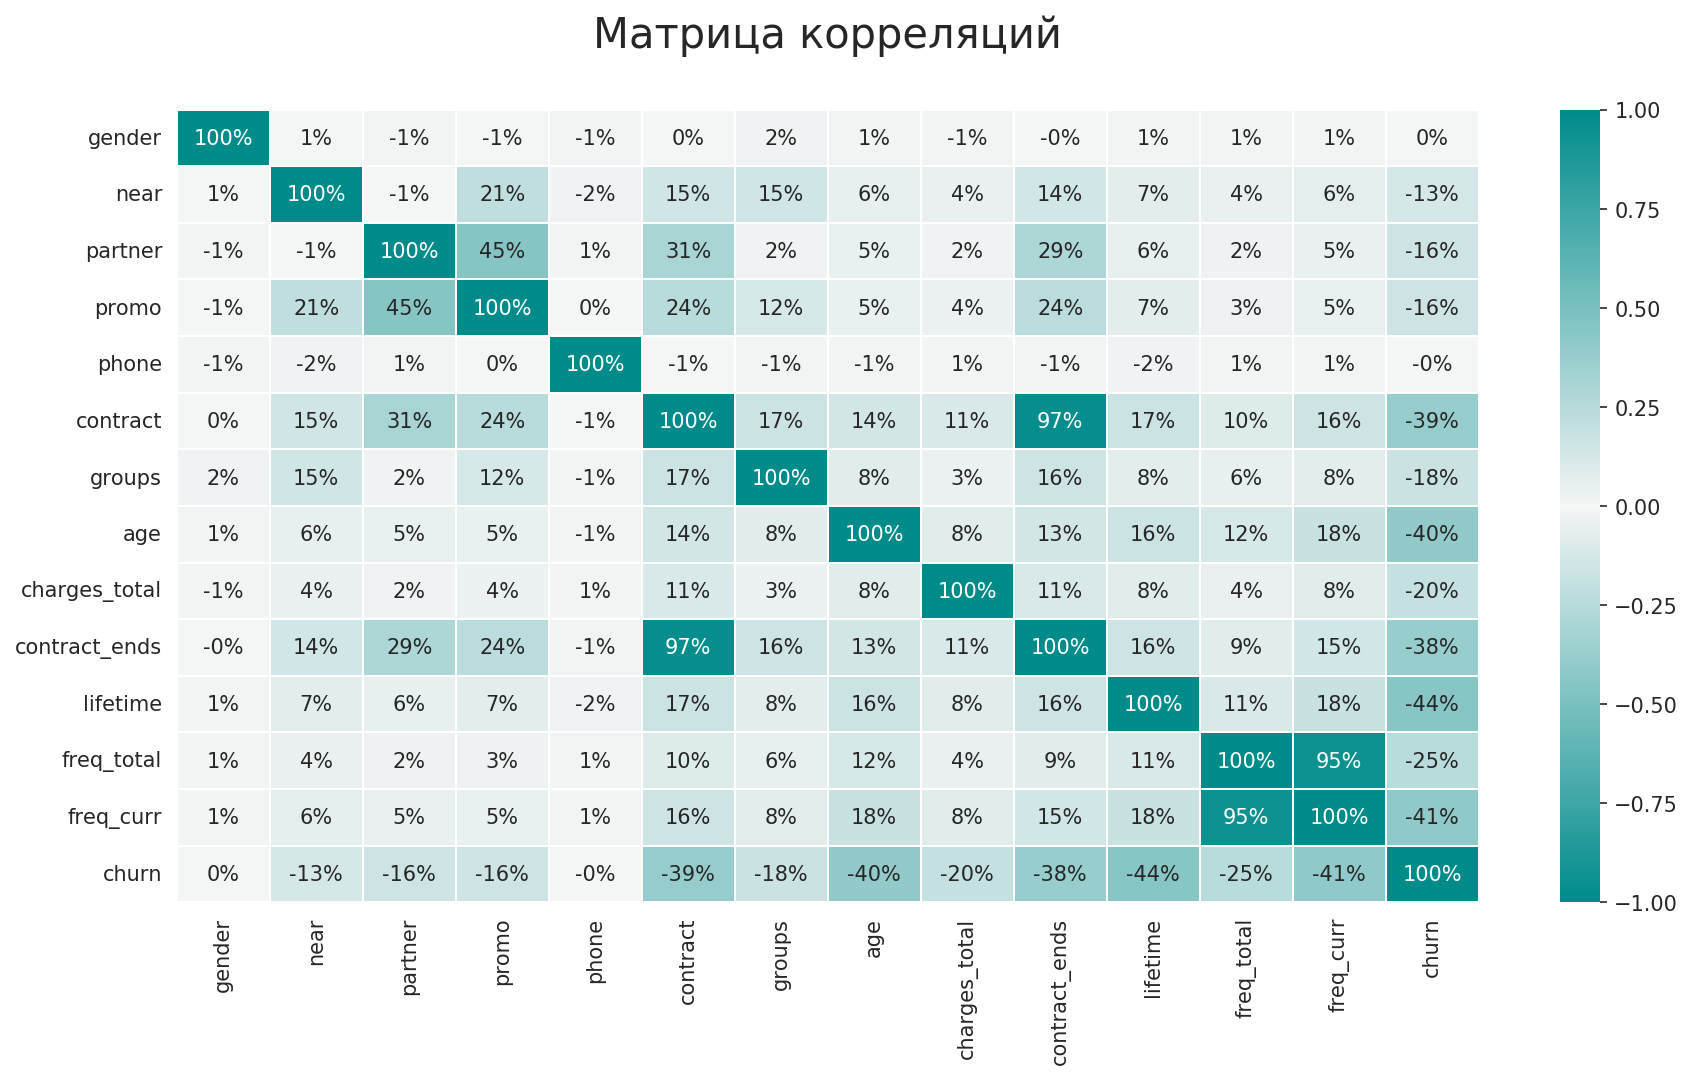

In [15]:
# создание цветовой карты, симметричной относительно центра

my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', ['darkcyan', 'whitesmoke', 'darkcyan'])


# график

space()
plt.figure(figsize=(14,7))
plt.title('Матрица корреляций', fontsize=20, pad=30)

graph = sns.heatmap(
                    data.corr(),
                    annot=True, fmt='0.0%',
                    vmin=-1, vmax=1,
                    linewidths=0.5,
                    cmap=my_cmap
                   )

graph.figure.dpi = plot_dpi
plt.show()

> Признаков, сильно коррелирующих с фактом оттока не обнаружилось. Максимум — это группа со слабо-средней корреляцией от 38 до 44%.
>
> Обнаружены 2 пары сильно кореллирующих признаков: `contract` и `contract_ends` – 97%, `freq_curr` и `freq_total` – 95%. В каждой паре один из признаков будет удален, чтобы избежать переобучения модели.

---
## Модели прогнозирования оттока клиентов

### Подготовка данных

In [16]:
# разделение на признаки и целевую переменную
x = data.drop('churn', axis=1)
y = data['churn']

# удаление признаков с сильной корреляцией (из группы коррелирующих признаков удаляются все кроме одного)
x = x.drop(['freq_curr', 'contract_ends'], axis=1)

# разделение на обучающую и валидационную выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

# стандартизация данных
scaler = StandardScaler()
scaler.fit(x_train)                     # обучение стандартизатора
x_train_st = scaler.transform(x_train)  # стандартизация признаков для обучения модели
x_test_st =  scaler.transform(x_test)   # стандартизация признаков для валидации модели

### Обучение моделей

In [17]:
# логистическая регрессия
LR_model = LogisticRegression(max_iter=100, solver='lbfgs', random_state=0) # создание модели
LR_model.fit(x_train, y_train)                                              # обучение модели
LR_predictions = LR_model.predict(x_test)                                   # прогноз
LR_probabilities =  LR_model.predict_proba(x_test)[:,1]                     # вероятность отнесения к классу

# случайный лес
RF_model = RandomForestClassifier(n_estimators=200, random_state=0)         # создание модели
RF_model.fit(x_train, y_train)                                              # обучение модели
RF_predictions = RF_model.predict(x_test)                                   # прогноз
RF_probabilities =  RF_model.predict_proba(x_test)[:,1]                     # вероятность отнесения к классу

In [18]:
# веса признаков модели Logistic Regression

display(
        pd.DataFrame(
                     {
                      'feature': x_train.columns,
                      'weight': abs(LR_model.coef_[0])
                     }
                    )
          .set_index('feature')
          .sort_values('weight', ascending=False)
          .style
                .background_gradient('Reds', high=1)
                .format('{:.3f}')
       )

,weight
feature,
lifetime,0.960
phone,0.735
near,0.589
freq_total,0.533
partner,0.426
promo,0.342
age,0.329
contract,0.265
groups,0.235


> Модель "Логистическая регрессия" придает большое значение признаку **phone** и невысокое признакам **contract** и **charges_total**. Довольно неожиданно.

In [19]:
# важность признаков модели Random Forest Classifier

display(
        pd.DataFrame(
                     {
                      'feature': x_train.columns,
                      'importance': abs(RF_model.feature_importances_)
                     }
                    )
          .set_index('feature')
          .sort_values('importance', ascending=False)
          .style
                .background_gradient('Reds', high=1)
                .format('{:.3f}')
       )

,importance
feature,
lifetime,0.333
freq_total,0.167
age,0.156
charges_total,0.133
contract,0.117
groups,0.021
partner,0.018
gender,0.017
promo,0.015


> Модель "Случайный лес" оценивает важность признаков ближе к интуитивно ожидаемой (за исключением **age**).  
> Требуется объективное непредвзятое сравнение моделей: самое время сравнить метрики.

### Сравнение метрик моделей

    Accuracy:  доля правильных ответов
    Precision: точность
    Recall:    полнота
    F1_score:  баланс между Precision и Recall
    ROC_AUC:   оценка качества классификатора

In [20]:
def print_metrics(title, y_true, y_pred, y_prob):
    print(title)
    print('\tAccuracy:  {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall:    {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1:        {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC:   {:.2f}'.format(roc_auc_score(y_true, y_prob)))
    space()


space()
print_metrics('Метрики модели логистической регрессии:', y_test, LR_predictions, LR_probabilities)
print_metrics('Метрики модели случайного леса:', y_test, RF_predictions, RF_probabilities)



Метрики модели логистической регрессии:
	Accuracy:  0.89
	Precision: 0.78
	Recall:    0.82
	F1:        0.80
	ROC_AUC:   0.95


Метрики модели случайного леса:
	Accuracy:  0.89
	Precision: 0.82
	Recall:    0.77
	F1:        0.79
	ROC_AUC:   0.95




> При заданных параметрах модели, построенные по алгоритмам **"Логистическая регрессия"** и **"Случайный лес",** проявили себя примерно одинаково: у одной чуть выше `Recall`, у другой – `Precision`.
>
> Можно попробовать подобрать оптимальные гиперпараметры моделей, например, с помощью цикла.
>
> Судить о превосходстве той или иной модели для данного исследования можно только после подбора оптимальных гиперпараметров. Помимо этого, возможно, придется учитывать время на подбор гиперпараметров и на работу самой модели.

---
## Кластеризация клиентов

### Матрица расстояний и дендрограмма

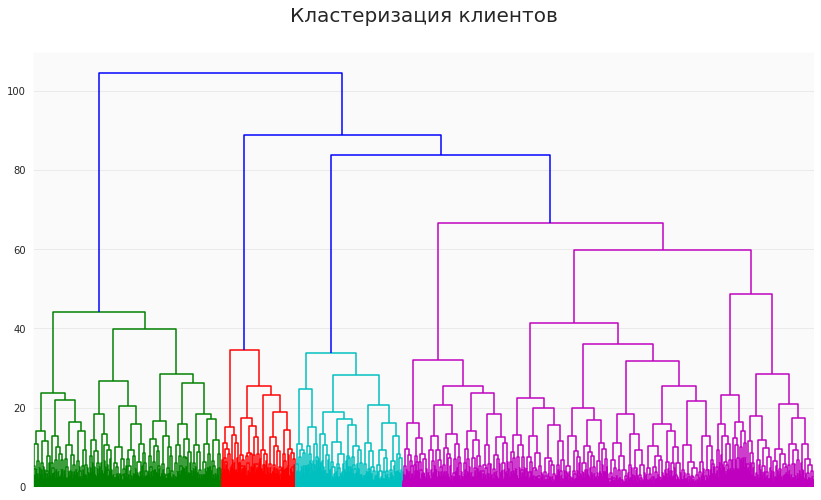

In [21]:
# выделение признаков
x = data.drop('churn', axis=1)

# создание и обучение стандартизатора, стандартизация данных
x_st = StandardScaler().fit_transform(x)

# матрица расстояний
linked = linkage(x_st, method='ward')

# дендрограмма
plt.figure(figsize=(14,8))  
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Кластеризация клиентов', size=20, pad=30)

space()
plt.show()

> Дендрограмма предложила 4 кластера, которые существенно различаются количеством клиентов. Самый большой кластер — первый претендент на дробление. При построении модели по алгоритму K-Means пока примем количество кластеров равным 5, но в дальнейшем можно продолжить эксперименты для оптимизации модели.

### Модель кластеризации на основе алгоритма K-Means

In [22]:
# создание и обучение модели K-Means
# кластеризация данных
# добавление инфо о кластеризации в общий dataframe

data['KM_cluster'] = KMeans(n_clusters=5, n_init=10, random_state=0).fit_predict(x_st)


# оценка качества кластеризации метрикой silhouette

silhouette = silhouette_score(x_st, data.KM_cluster)
print('\n', 'Метрика Silhouette для модели K-Means: {:.4f}'.format(silhouette))


 Метрика Silhouette для модели K-Means: 0.1414


> Метрика Silhouette оценила полученную модель довольно скромно. Увеличение значения параметра `n_init` не дало результата. При изменением числа кластеров метрика изменялась незначительно.

### Средние значения признаков для кластеров

In [23]:
# замена названий кластеров
# названия выбраны в зависимости от среднего значения churn

data.KM_cluster = data.KM_cluster.replace(0, 'A1')   # churn = 0.028
data.KM_cluster = data.KM_cluster.replace(4, 'A2')   # churn = 0.068
data.KM_cluster = data.KM_cluster.replace(1, 'B')    # churn = 0.268
data.KM_cluster = data.KM_cluster.replace(2, 'C1')   # churn = 0.444
data.KM_cluster = data.KM_cluster.replace(3, 'C2')   # churn = 0.514


# упорядоченный список полей (целевая переменная churn + признаки)

fields_sorted = ['churn'] + features_sorted


# таблица средних значений, сгруппированная по кластерам

space()
display(
        data
        .groupby('KM_cluster')
        [fields_sorted]       # перестановка признаков в порядке убывания их предполагаемой связи с churn
        .mean()
        .style
              .background_gradient('Reds', subset='churn', high=1)
              .format('{:.1%}', subset='churn')
       )


# таблица средних значений без деления на кластеры

display(
        data
        [fields_sorted]       # перестановка признаков в порядке убывания их предполагаемой связи с churn
        .mean()
        .to_frame(name='all_avarage')
        .T
        .style.format('{:.1%}', subset='churn')
       )
space()

,churn,lifetime,contract,contract_ends,freq_curr,promo,groups,partner,charges_total,freq_total,near,age,gender,phone
KM_cluster,,,,,,,,,,,,,,
A1,2.8%,4.74,10.9,9.95,1.98,0.575,0.543,0.783,161,1.98,0.959,30,0.502,1
A2,6.8%,4.9,2.67,2.46,2.85,0.229,0.473,0.356,162,2.85,0.976,30.1,0.56,0.999
B,26.8%,3.92,4.79,4.48,1.72,0.306,0.426,0.47,144,1.85,0.862,29.3,0.522,0
C1,44.4%,2.81,2.35,2.2,1.48,0.0792,0.216,0.463,135,1.66,0,28.5,0.495,1
C2,51.4%,2.44,1.95,1.86,1.01,0.24,0.342,0.35,132,1.25,1,28.2,0.486,1


,churn,lifetime,contract,contract_ends,freq_curr,promo,groups,partner,charges_total,freq_total,near,age,gender,phone
all_avarage,26.5%,3.72,4.68,4.32,1.77,0.308,0.412,0.487,147,1.88,0.845,29.2,0.51,0.903


> По доле оттока полученные кластеры можно разделить на несколько условных групп.
>
> **A-класс (надежные)**  
> В кластерах **A1** и **A2** отток невелик и составляет около **3%** и **7%** соответственно. Здесь собраны в целом надежные клиенты.
>
> **B-класс (сомневающиеся)**  
> Кластер **B** имеет отток на уровне среднего значения для всего набора данных, **27%**, и который условно можно назвать группой сомневающихся.
>
> **С-класс (ненадежные)**  
> Лидеры по оттоку — кластеры **C1** и **C2**, в которых средние значения оттока **44%** и **51%** говорят о  вероятности потери каждого второго клиента в ближайшем будущем.

> **Анализ признаков кластеров**
>
> **А1 / А2**  
> **lifetime:** выше среднего / выше среднего  
> **contract** и **contract_ends:** сильно выше среднего / среднее  
> **freq_curr** и **freq_total:** выше среднего / много выше среднего  
> **promo:** много выше среднего / ниже среднего  
> **groups:** много выше среднего / выше среднего  
> **partner:** много выше среднего / ниже среднего  
> **charges_total:** слегка выше среднего / слегка выше среднего  
> **near:** слегка выше среднего / слегка выше среднего  

> **В**  
> **lifetime:** среднее  
> **contract** и **contract_ends:** среднее  
> **freq_curr** и **freq_total:** среднее  
> **promo:** среднее  
> **groups:** среднее  
> **partner:** среднее  
> **charges_total:** среднее  
> **near:** среднее  

> **С1 / С2**  
> **lifetime:** ниже среднего / ниже среднего  
> **contract** и **contract_ends:** сильно ниже среднего / сильно ниже среднего  
> **freq_curr** и **freq_total:** ниже среднего / ниже среднего  
> **promo:** много ниже среднего / ниже среднего  
> **groups:** много ниже среднего / ниже среднего  
> **partner:** среднее / много ниже среднего  
> **charges_total:** ниже среднего / ниже среднего  
> **near:** 0 / 1  

> **age** и **gender** между кластерами различаются слабо.  
> **phone** между кластерами различается слабо, за исключением кластера **B**, в котором собраны (почти) все клиенты, не указавшие номер телефона.  
> **near** между кластерами различается слабо, за исключением кластеров **С1** и **С2**, поделенных преимущественно по этому признаку.  
> **promo** показал себя неоднозначно: для кластера **А1** он выше среднего, для кластера **А2** — наоборот.
>
> Про остальные признаки можно сказать: чем выше значение, тем больше вероятность, что клиент попадет в более надежный класс (А, В или С).

### Распределения признаков для кластеров

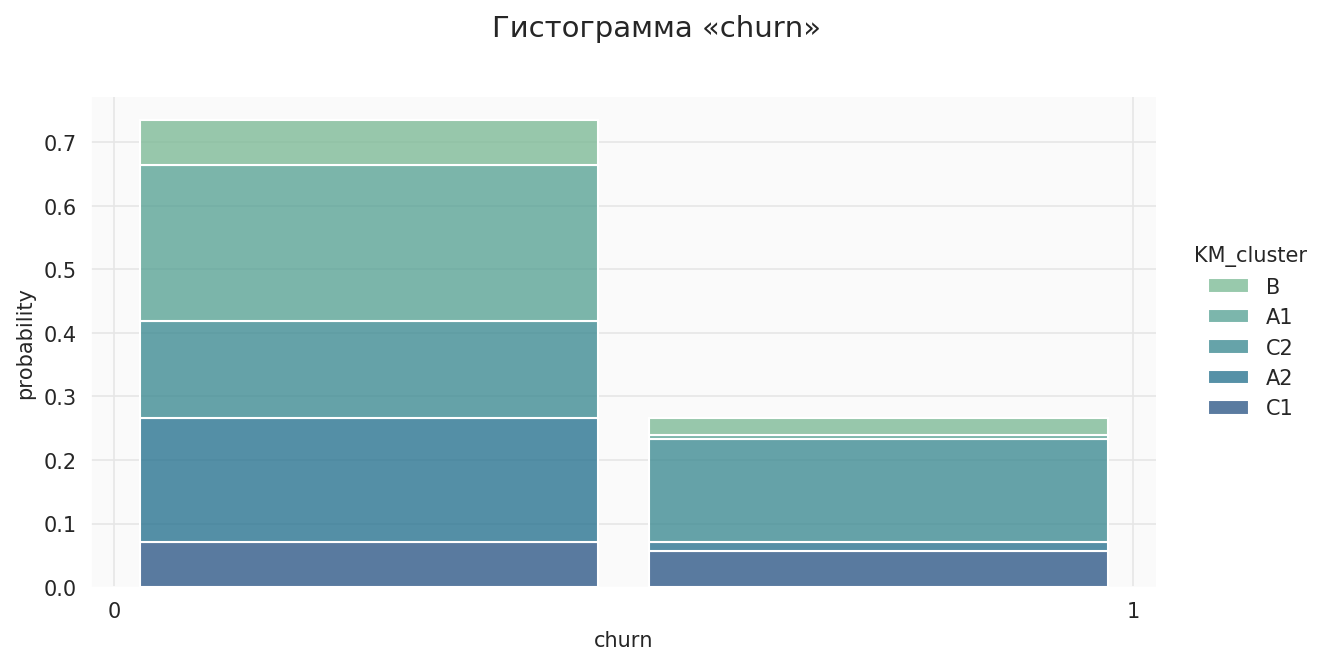

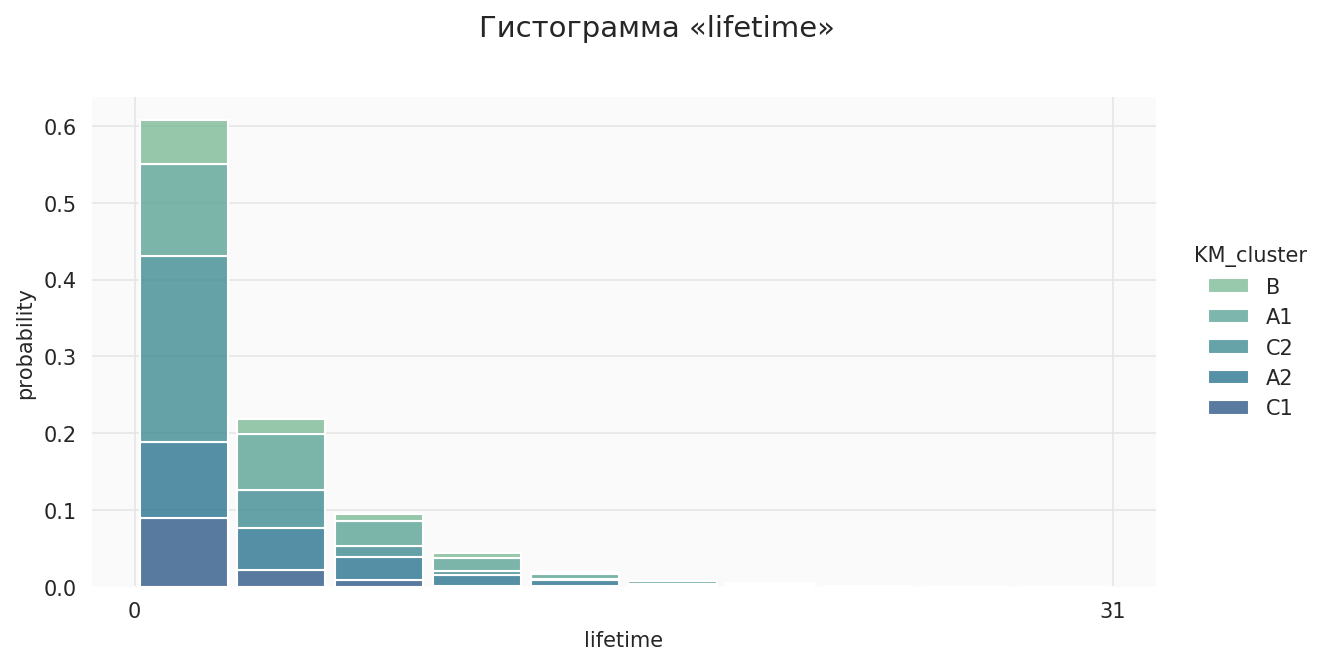

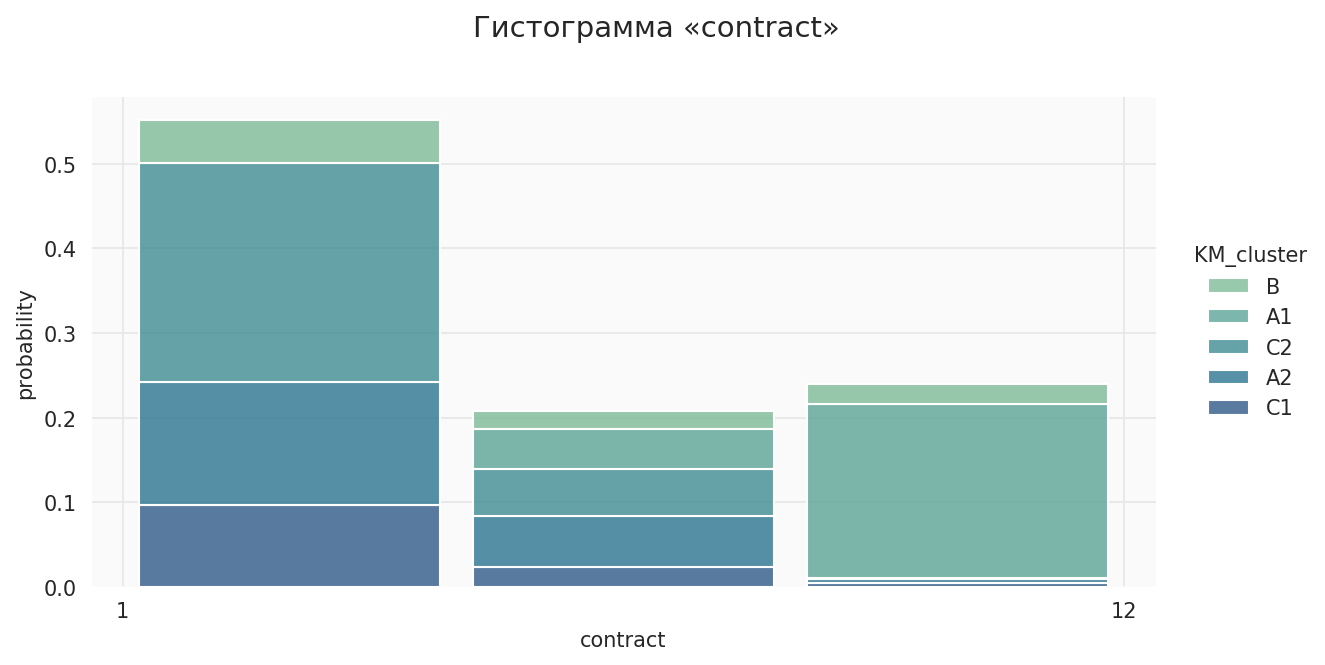

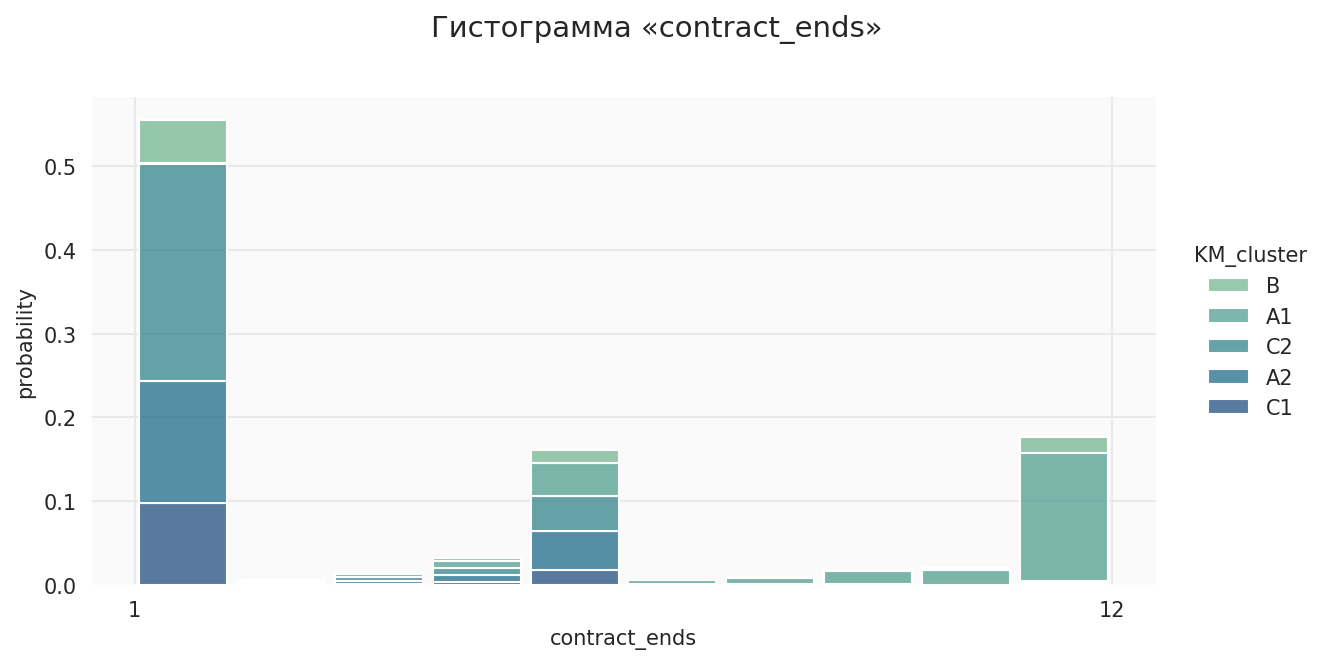

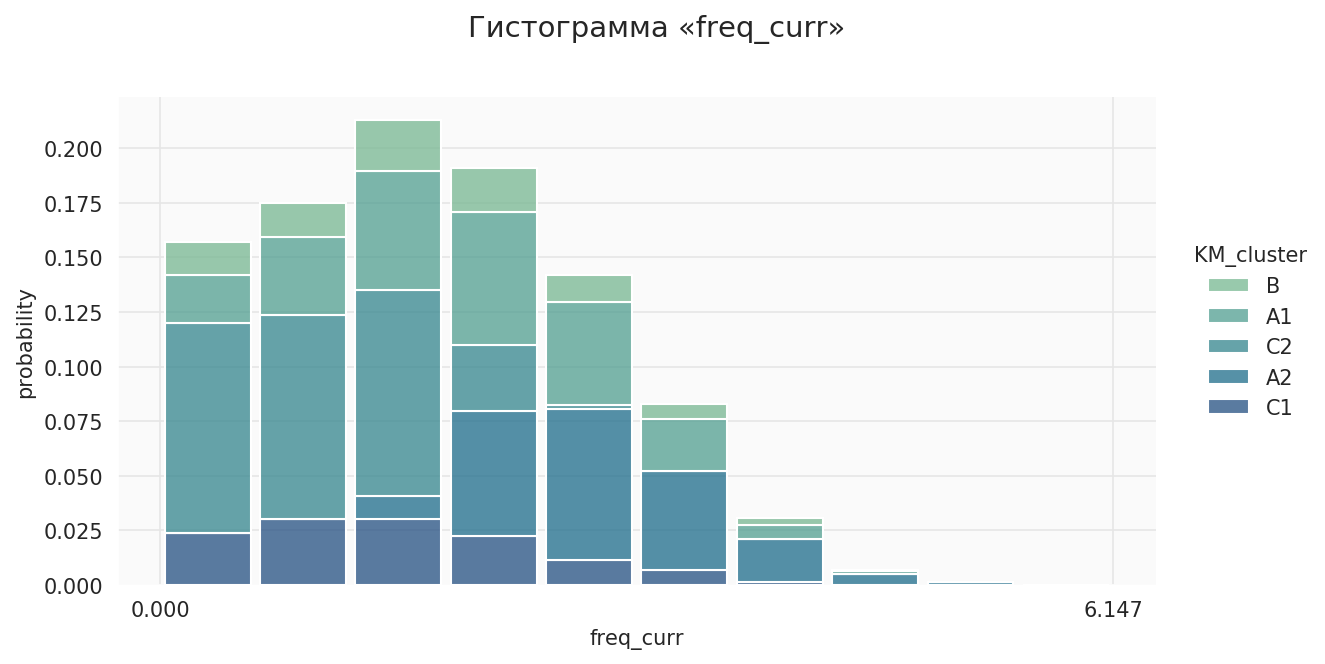

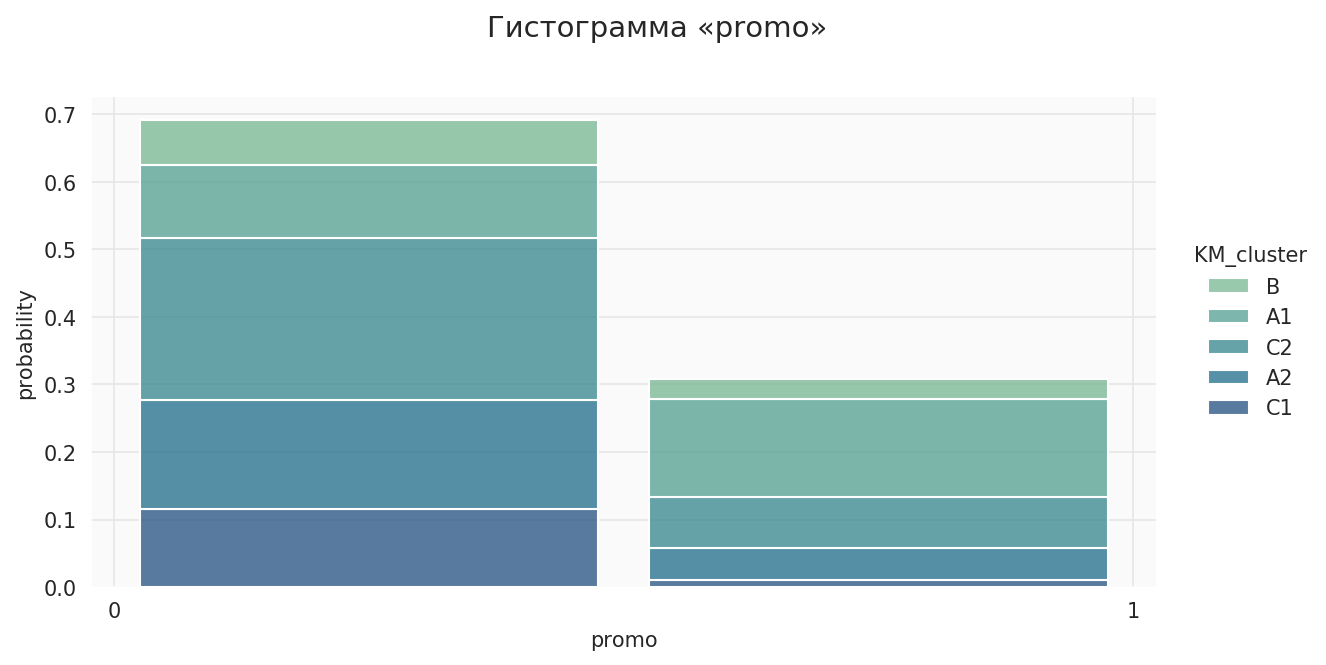

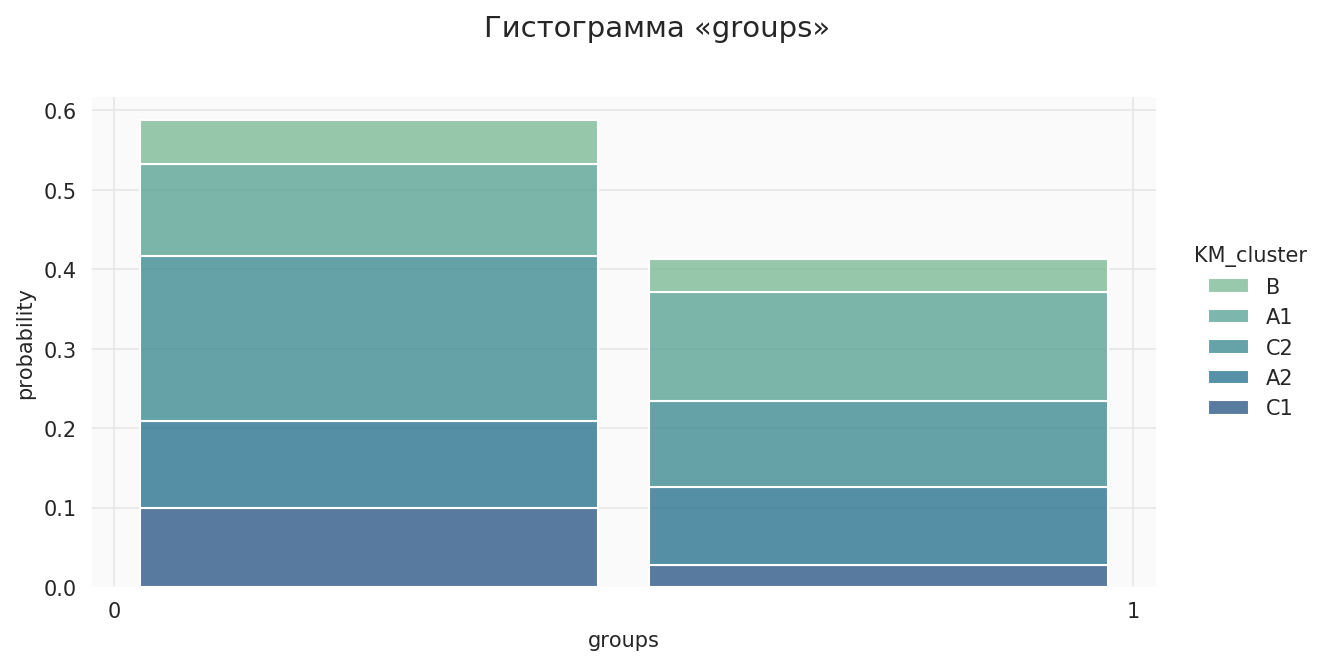

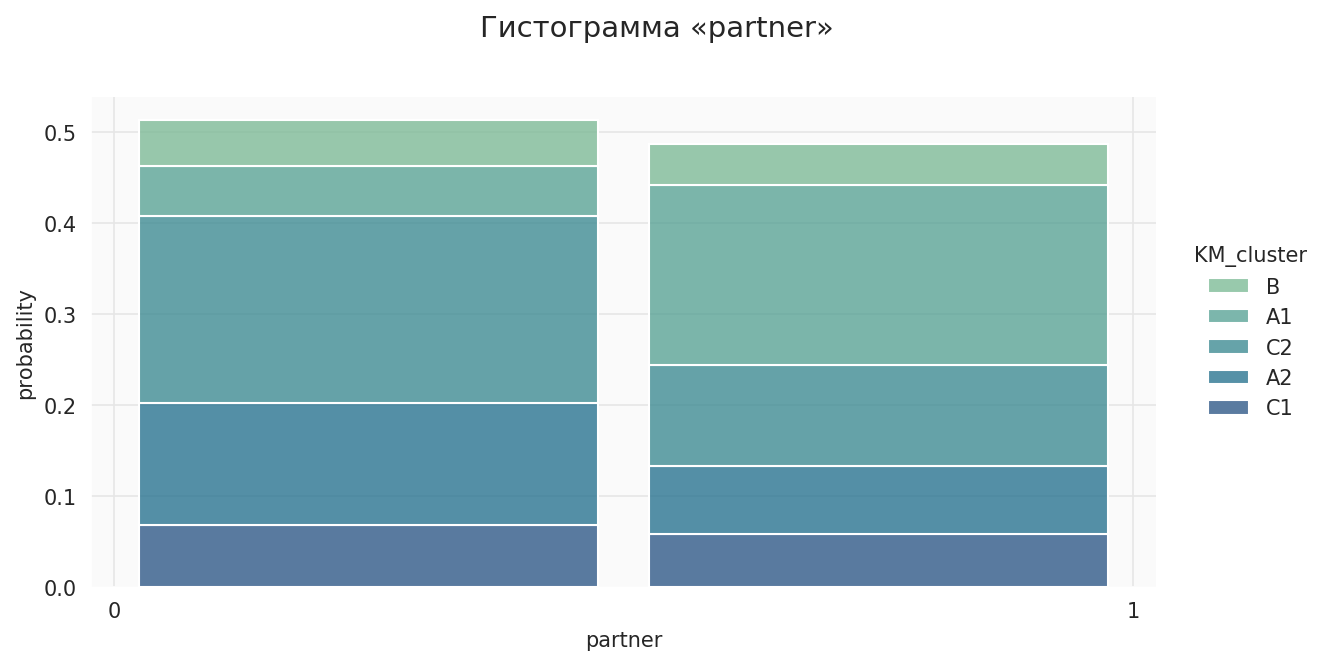

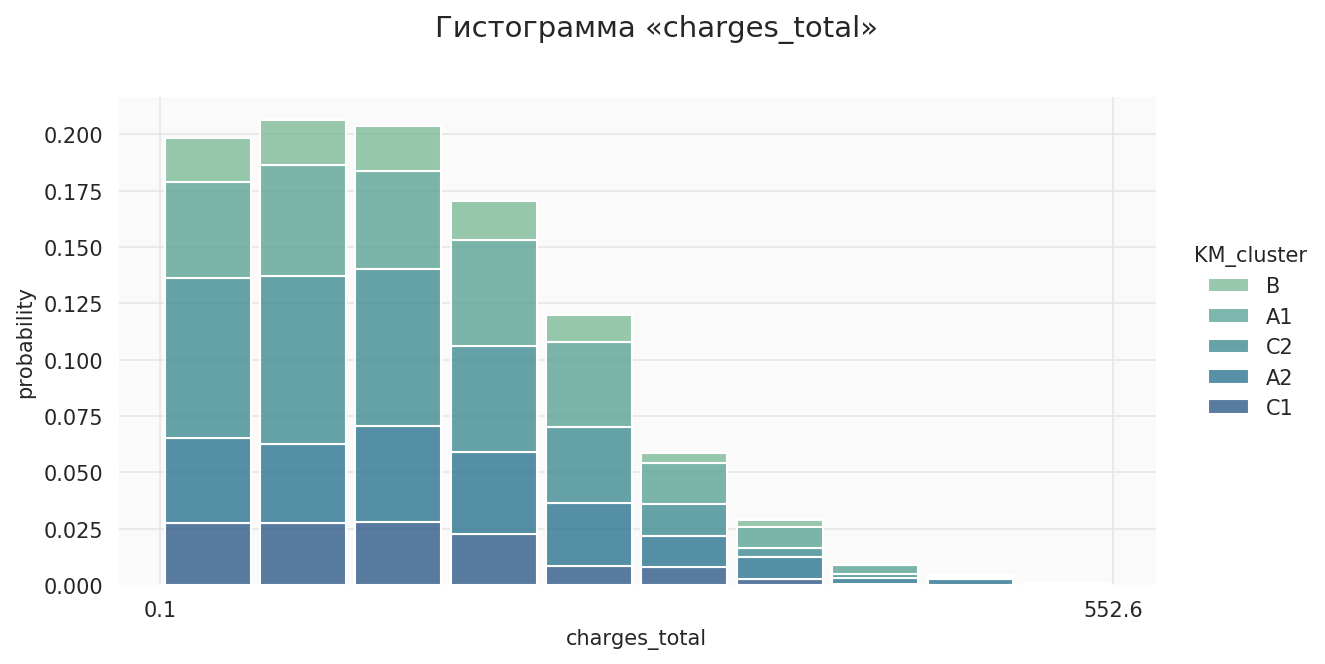

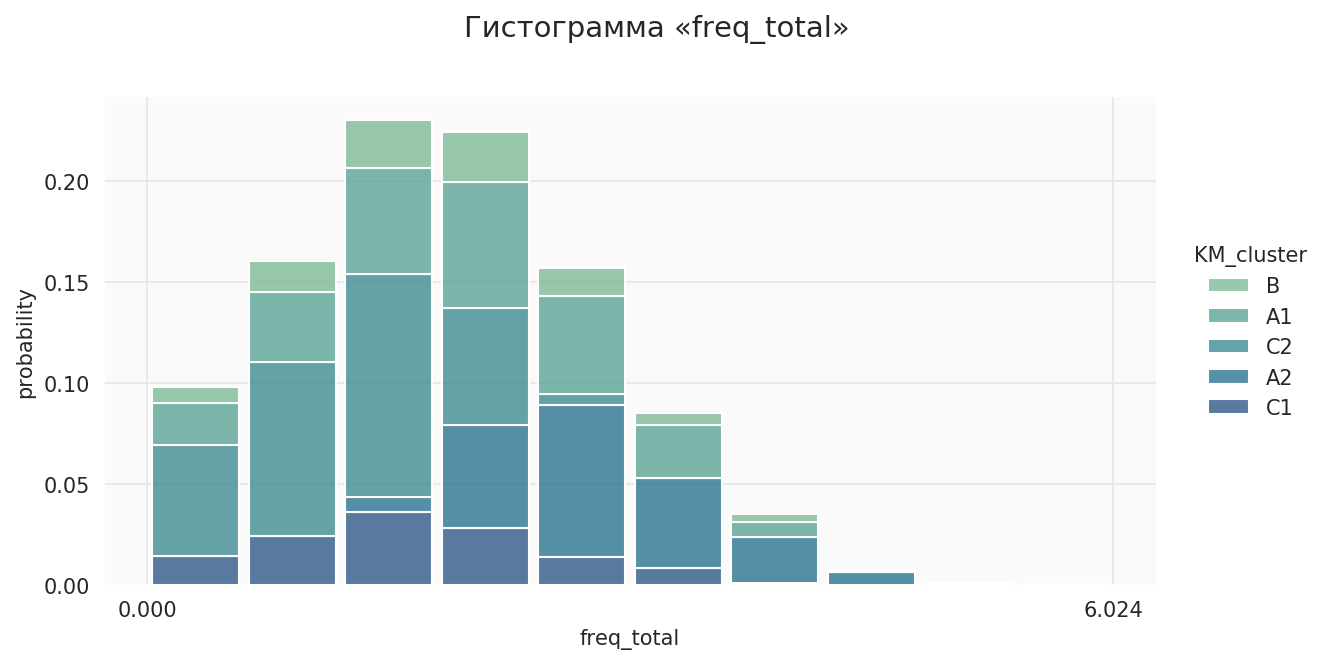

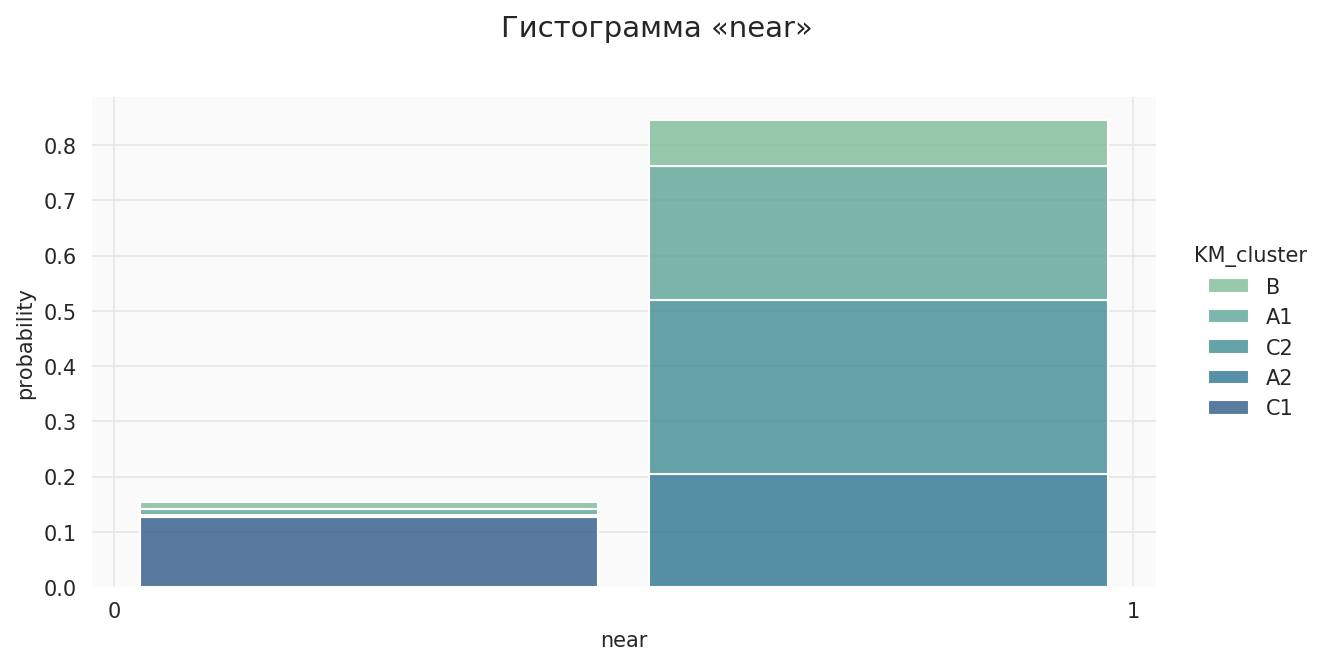

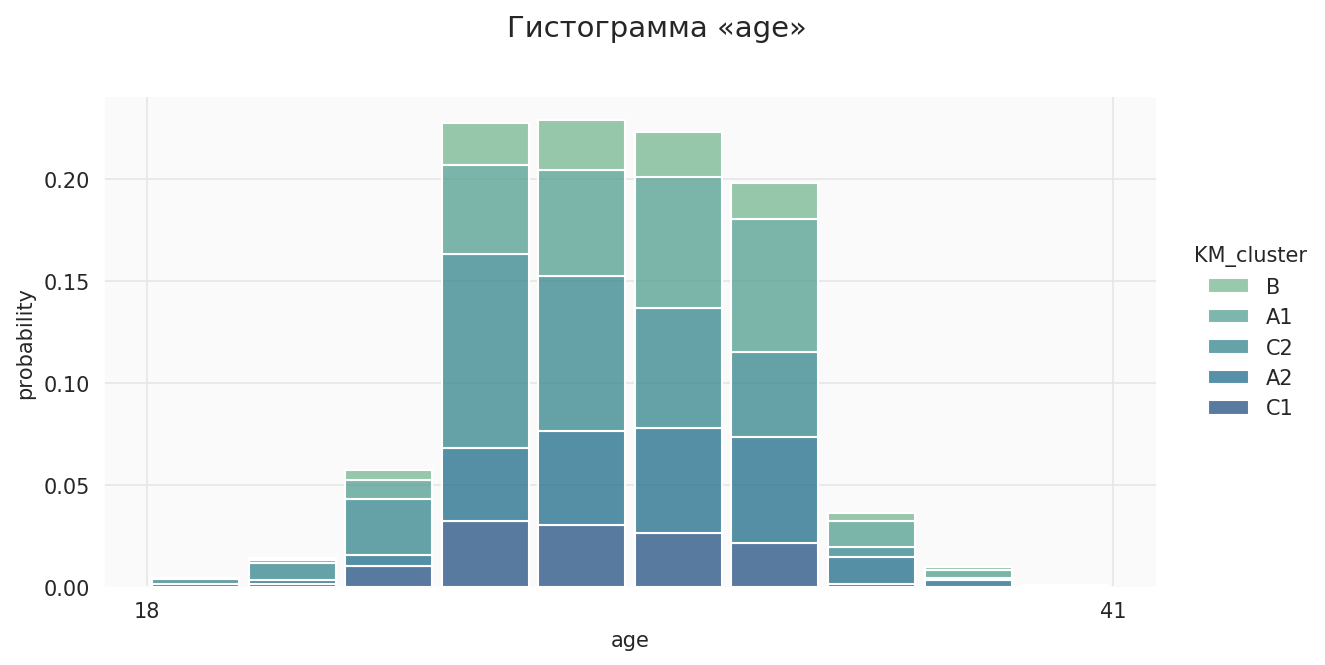

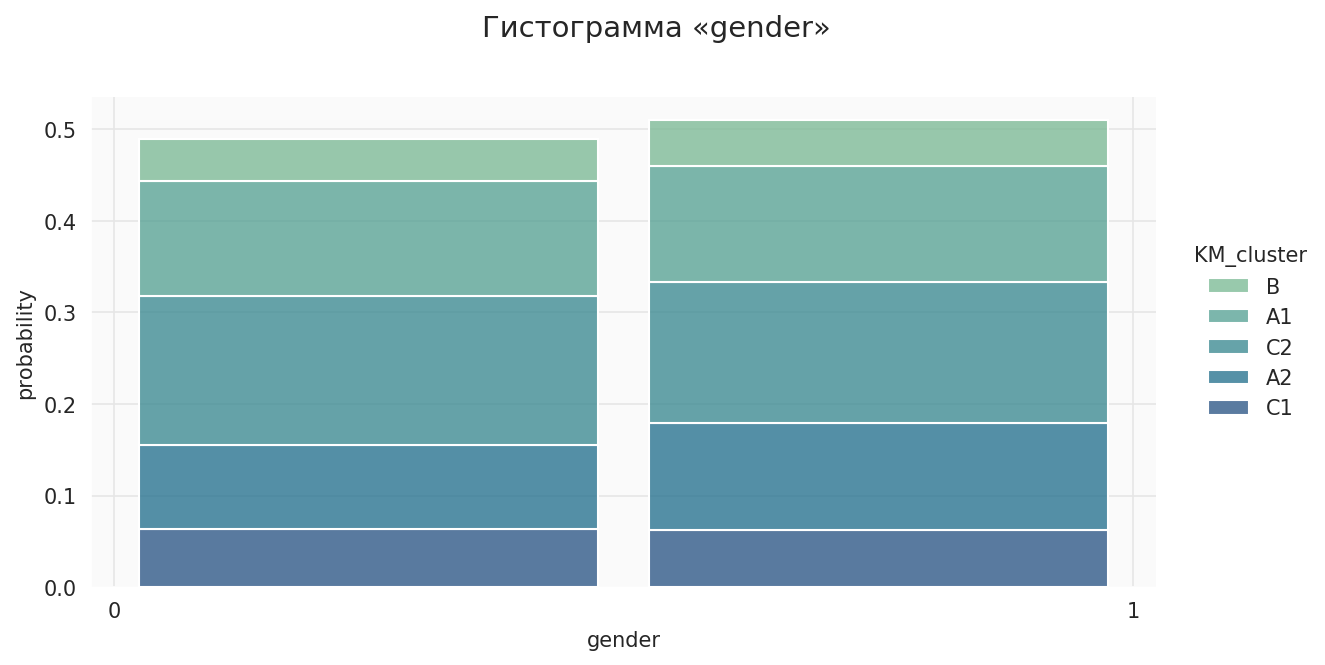

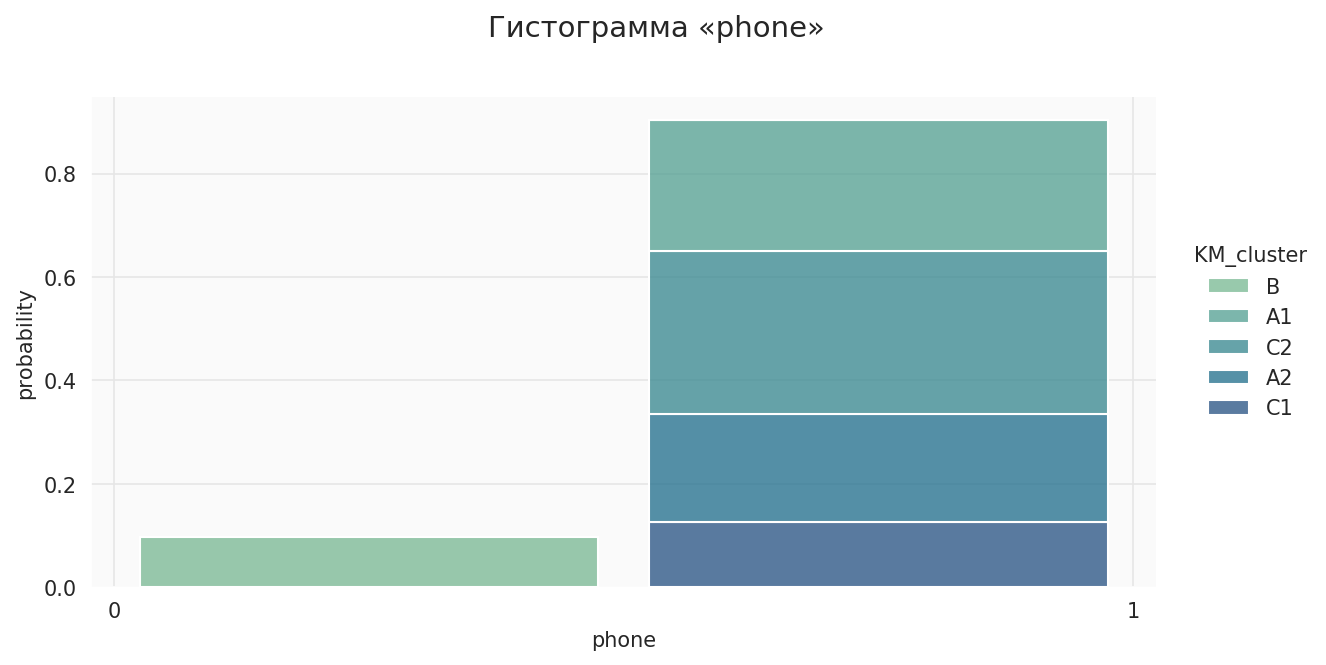

In [24]:
for column in fields_sorted:                 # порядок сортировки, см. п.2.2

    # определение количества корзин
    if data[column].nunique() < 10:
        n_bins = data[column].nunique()
    else:
        n_bins = 10
    
    graph = sns.displot(
                        data=data,
                        x=column,
                        hue='KM_cluster',
                        multiple='stack',
                        bins=n_bins,
                        stat='probability',
                        height=4, aspect=2,
                        shrink=.9,
                        palette='crest'
                       )
    
    graph.set_axis_labels(column, 'probability')
    graph.figure.dpi = plot_dpi
    graph.set(xticks=[data[column].min(),data[column].max()])                            # оцифровка шкалы
    graph.figure.suptitle(f'Гистограмма «{column}»', fontsize=14, y=1.1)
    
    space()
    plt.show()

> По данным гистограммам можно судить о распределении целевой переменной **churn** и признаков по кластерам.
>
> Гистограммы не содержат деление по значению **churn**, поскольку в сочетании с делением на кластеры это сделало бы их трудночитаемыми.

### Доля оттока по кластерам

In [25]:
display(
        data.groupby('KM_cluster')
            .agg({'churn':'mean'})
            .sort_values('churn')
            .style
                  .background_gradient('Reds', high=1)
                  .format('{:.1%}')
       )

,churn
KM_cluster,
A1,2.8%
A2,6.8%
B,26.8%
C1,44.4%
C2,51.4%


---
## Вывод

### Краткий обзор проведенной работы

В данном исследовании были изучены данные из базы данных заказчика (анкетные данные клиентов, журнал посещений и покупок, статус абонемента клиента). Оценено качество подготовки этих данных. Была проведена работа по улучшению качества входных данных: исправлены мелкие недочеты, данные представлены в более удобном виде.

Выполнено:
- проведен предварительный анализ входных данных;
- построена модель бинарной классификации клиентов для прогнозирования оттока клиента;
- клиенты разбиты на характерные кластеры;
- проведен предварительный анализ признаков выделенных кластеров, склонность кластеров к оттоку;
- определены потенциальные риски данного исследования, возможности их устранения;  
- даны рекомендации по дальнейшему развитию данного исследования.

### Результаты

Для предварительной оценки связи признаков с оттоком было оценено соотношение средних значений признаков для оставшихся и ушедших клиентов. Полученные результаты отсортированы по убыванию важности. В дальнейшем этот порядок признаков был использован при построении таблиц и графиков.

Построены парные гистограммы признаков, при попарном сравнении которых можно предположить силу связи между отдельным признаком и фактом оттока.

Построена матрица корреляций, позволившая выявить сильно коррелирующие признаки, которые могли привести к переобучению модели.

Были построены и сравнены между собой две модели для предсказания оттока клиента по алгоритмам **логистической регрессии** и **случайного леса**. Для сравнения моделей использовался набор метрик: **Accuracy**, **Precision**, **Recall**, **F1** и **ROC_AUC**. Обе модели показали себя примерно одинаково (гиперпараметры специально были так подобраны). Судить о превосходстве той или иной модели для данного исследования можно только после подбора оптимальных гиперпараметров. Помимо этого, возможно, придется учитывать время на подбор гиперпараметров и на работу самой модели.

Произведена кластеризация клиентов: построена дендрограмма на основе матрицы расстояний и модель по алгоритму **K-Means**. Модель получила невысокую оценку метрики **Silhouette**.

Для кластеров создана таблица средних значений признаков и целевой переменной. Каждый кластер получил описание характериных для него значений признаков. Для каждого кластера была расчитана доля клиентов, ушедших в отток в предыдущем месяце.

На основании построенных моделей и созданных кластеров можно выполнить прогнозирование оттока клиентов в следующем месяце по текущим данным.

### Рекомендации и риски

Для повышения качества данного исследования будет полезна дополнительная информация о фитнес-клубе: как давно открыт, является ли сетевым, есть ли выраженная направленность, какие акцие действовали и действуют сейчас и т.д.

Если клуб проводит кампанию по активному расширению, прогнозная модель, построенная в данном исследовании, может оказаться неэффективной, поскольку по окончании процесса расширения условия изменятся.

Хотя **lifetime** и является самым надежным (весомым) признаком на данный момент, он может утратить свой вес, если клуб находится в активной стадии перемен, и часть "старых" клиентов, которых немного, не согласится с переменами и уйдет.

Судить о превосходстве модели, построенной на базе того или иного алгоритма, можно только после подбора оптимальных гиперпараметров. Рекомендуется продолжить поиск оптимальных гиперпараметров.

Для повышения качества моделей можно попробовать исключить признаки **age**, **gender**, **phone** и **near** (в различных комбинациях).

---

Рекомендации для улучшения стратегии удержания клиентов:
- в 10 раз снизить цены;
- не требовать одевать бахиллы;
- раздавать бесплатные протеиновые коктейли;
- обеспечить социальную дистанцию 1.5 метра (а лучше 5).

А если серьезно, как можно рекомендовать принимать важные решения, не имея ни какой информации о клубе, а лишь на основании урезанной выборки, полученной в неизвестных условиях?

## The End